# Genetic Distance Approximation (due_202203, 1250 sequences)
This notebook contains the evaluation of the genetic distance approximation concerning the aggregate due_202203 with 1,250 sequences. The distance matrices were evaluated in terms of correlation, errors, as well as infection recall and precision.


In [1]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=27239 sha256=4f64cca541a9e1aa9126336cf32ac717bb3dce88811a4cec6c64399e38e1724e
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-tcwce4e6/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
from sklearn.metrics import adjusted_rand_score
import numpy as np
from gentrain.evaluation import candidate_evaluation_and_matrices, get_candidate_evaluation_and_export_mst, get_infection_detection_scores, get_lineage_purity
from gentrain.encoding import get_nucleotide_sensitive_encodings, get_mutation_sensitive_encodings, generate_one_hot_encoding
from gentrain.nextclade import get_mutations_from_dataframe
from gentrain.candidate_sourcing import bitwise_xor_candidates
from gentrain.graph import build_mst, export_graph_gexf, mean_edge_weight, get_outbreak_community_labels, build_graph
from gentrain.distance_matrix import get_bitwise_xor_distance_matrix, get_kendall_tau_correlation, get_infection_recall, get_infection_precision, get_infection_f1, get_signed_rmse, get_signed_infection_rmse
import os
import shutil
import plotly.express as px

In [3]:
import plotly.io as pio
pio.renderers.default = "png"

In [4]:
aggregate = "due_202203"
size = 1250

In [5]:
graph_path = f"graphs/{aggregate}/{size}"
if os.path.exists(f"graphs/{aggregate}/{size}") and os.path.isdir(f"graphs/{aggregate}/{size}"):
    shutil.rmtree(f"graphs/{aggregate}/{size}")
if not os.path.exists(f"graphs/{aggregate}"):
    os.mkdir(f"graphs/{aggregate}")
os.mkdir(f"graphs/{aggregate}/{size}")

In [6]:
sequences_df = pd.read_csv(f"../00_data_understanding_and_preparation/aggregates/{aggregate}/{size}/sequences_and_metadata.csv", delimiter=";").set_index("igs_id").sort_index()
sequences_count = len(sequences_df)

In [7]:
mutations_df = get_mutations_from_dataframe(sequences_df)

In [8]:
distance_matrix_df = pd.read_csv(f"../01_algorithm_optimization/distance_matrices/{aggregate}/{size}/distance_matrix.csv", delimiter=";",
                                     index_col="Unnamed: 0").sort_index()
distance_matrix_df = distance_matrix_df[~distance_matrix_df.index.duplicated(keep="first")]
distance_matrix_df = distance_matrix_df.loc[sequences_df.index, sequences_df.index]
distance_matrix = distance_matrix_df.to_numpy()

In [9]:
gentrain_graph = build_graph(distance_matrix)
gentrain_mst = build_mst(gentrain_graph)
gentrain_community_labels = get_outbreak_community_labels(gentrain_mst)
datetime_sampling_dates = pd.to_datetime(sequences_df["date_of_sampling"])
numeric_dates = (datetime_sampling_dates - datetime_sampling_dates.min()).dt.days
export_graph_gexf(gentrain_mst, gentrain_community_labels, sequences_df, f"{graph_path}/gentrain")

mst generation time: 1.75s


In [10]:
from collections import Counter
np.median(distance_matrix), mean_edge_weight(gentrain_mst), len(Counter(gentrain_community_labels))

(np.float64(8.0), np.float64(2.0078462770216103), 70)

In [11]:
mask = np.triu(np.ones(distance_matrix_df.shape), k=1).astype(bool)
filtered = distance_matrix_df.where(mask)
infections_count = (filtered < 2).sum().sum()
distances_count = filtered.count().sum()

In [12]:
encodings_no_filter = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=False, filter_N=False)
encodings_N_frequency_filtering = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=False, filter_N=True)
encodings_N_and_SNV_frequency_filtering = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=True, filter_N=True)

execution time: 24.73s
execution time: 27.07s
execution time: 26.1s


In [13]:
evaluation = []

In [14]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_no_filter)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["Nextclade_pango"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/no_filter")

evaluation.append({
    "label": "No Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_no_filter[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 1.03s
mst generation time: 1.95s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(1.9664531625300308), np.float64(-0.1552))

In [15]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_N_frequency_filtering)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["Nextclade_pango"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/N_frequency_filtering")

evaluation.append({
    "label": "N Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_N_frequency_filtering[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 0.9s
mst generation time: 1.84s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(0.7587670136108846), np.float64(-0.060799999999999965))

In [16]:
observed_matrix = get_bitwise_xor_distance_matrix(encodings_N_and_SNV_frequency_filtering)
observed_graph = build_graph(observed_matrix)
observed_mst = build_mst(observed_graph)
observed_community_labels = get_outbreak_community_labels(observed_mst)
lineage_purity = get_lineage_purity(list(sequences_df["Nextclade_pango"]), observed_community_labels)
export_graph_gexf(observed_mst, gentrain_community_labels, sequences_df, f"{graph_path}/N_and_SNV_frequency_filtering")

evaluation.append({
    "label": "N and SNV Filter",
    "correlation": get_kendall_tau_correlation(distance_matrix, observed_matrix), 
    "signed_rmse": get_signed_rmse(distance_matrix, observed_matrix), 
    "signed_infection_rmse": get_signed_infection_rmse(distance_matrix, observed_matrix), 
    "infection_recall": get_infection_recall(distance_matrix, observed_matrix), 
    "infection_precision": get_infection_precision(distance_matrix, observed_matrix), 
    "infection_f1": get_infection_f1(distance_matrix, observed_matrix), 
    "median_distance": np.median(observed_matrix),
    "community_count_diff": len(Counter(observed_community_labels))-len(Counter(gentrain_community_labels)),
    "adjusted_rand_index": adjusted_rand_score(gentrain_community_labels, observed_community_labels),
    "mean_edge_weight": mean_edge_weight(observed_mst),
    "lineage_purity": lineage_purity,
    "encoding_length": len(encodings_N_and_SNV_frequency_filtering[0])
})
mean_edge_weight(observed_mst)-mean_edge_weight(gentrain_mst),lineage_purity-get_lineage_purity(list(sequences_df["clade"]), gentrain_community_labels)

matrix generation time: 0.26s
mst generation time: 1.73s


/Users/benkraling/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/community/community_louvain.py:487: RuntimeWarning:

overflow encountered in scalar negative



(np.float64(-0.8703763010408303), np.float64(-0.012800000000000034))

In [17]:
pd.DataFrame(evaluation)

,label,correlation,signed_rmse,signed_infection_rmse,infection_recall,infection_precision,infection_f1,median_distance,community_count_diff,adjusted_rand_index,mean_edge_weight,lineage_purity,encoding_length
0,No Filter,0.670808,10.579679,12.729306,0.135726,0.910949,0.236252,17.0,-54,0.127023,3.974299,0.8064,2048
1,N Filter,0.815802,-3.832490,7.142669,0.517781,0.799228,0.628432,10.0,23,0.177467,2.766613,0.9008,1936
2,N and SNV Filter,0.745165,-21.422286,1.236872,0.785753,0.194891,0.312318,6.0,9,0.200300,1.137470,0.9488,624


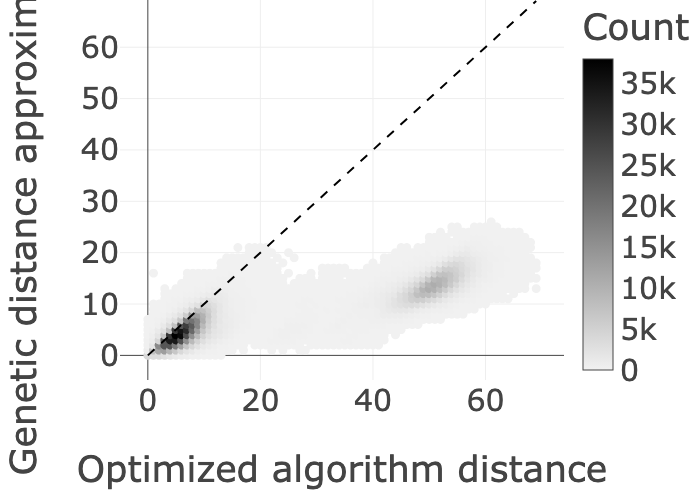

In [18]:
gentrain_flatten = distance_matrix.flatten()
approximated_flatten = observed_matrix.flatten()
data = pd.DataFrame({
    "gentrain": gentrain_flatten,
    "optimized": approximated_flatten
})


data = data.groupby(["gentrain", "optimized"]).size().reset_index(name="count")

fig = px.scatter(data, x="gentrain", y="optimized", color="count", color_continuous_scale=[[0, "#f1f1f1"], [1, "#000000"]], labels={"count": "Count"})

fig.add_shape(
    type="line",
    x0=min(gentrain_flatten.min(), approximated_flatten.min()),
    y0=min(gentrain_flatten.min(), approximated_flatten.min()),
    x1=max(gentrain_flatten.max(), approximated_flatten.max()),
    y1=max(gentrain_flatten.max(), approximated_flatten.max()),
    line=dict(color="black", width=2, dash="dash"),
    name="y = x",
)
fig.update_layout(width=1000, height=1000,template="presentation",font=dict(size=30),  xaxis=dict(
        title=dict(
              text="Optimized algorithm distance",
            standoff=40
        ),
        tickangle=0
    ),
    margin=dict(l=120,r=0,t=0,b=120),
    yaxis=dict(
        title=dict(
            text="Genetic distance approximation",
            standoff=40
        ),
        tickangle=0
    ),)
fig.show()
fig.write_image("figures/approximation_offset_due_202203.svg", width=1000, height=1000)